In [3]:
from onnxruntime.training import artifacts
import torch
import onnx
import io
import netron

# Pytorch class that we will use to generate the graphs.
class MNISTNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MNISTNet, self).__init__()

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, model_input):
        out = self.fc1(model_input)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create a MNISTNet instance.
device = "cpu"
batch_size, input_size, hidden_size, output_size = 64, 784, 500, 10
pt_model = MNISTNet(input_size, hidden_size, output_size).to(device)

# Generate a random input.
model_inputs = (torch.randn(batch_size, input_size, device=device),)

input_names = ["input"]
output_names = ["output"]
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

f = io.BytesIO()
torch.onnx.export(
    pt_model,
    model_inputs,
    f,
    input_names=input_names,
    output_names=output_names,
    opset_version=14,
    do_constant_folding=False,
    training=torch.onnx.TrainingMode.TRAINING,
    dynamic_axes=dynamic_axes,
    export_params=True,
    keep_initializers_as_inputs=False,
)
onnx_model = onnx.load_model_from_string(f.getvalue())

requires_grad = [name for name, param in pt_model.named_parameters() if param.requires_grad]

frozen_params = [name for name, param in pt_model.named_parameters() if not param.requires_grad]

artifacts.generate_artifacts(
    onnx_model,
    optimizer=artifacts.OptimType.AdamW,
    loss=artifacts.LossType.CrossEntropyLoss,
    requires_grad=requires_grad,
    frozen_params=frozen_params,
    additional_output_names=output_names)

netron.start("eval_model.onnx")

Serving 'eval_model.onnx' at http://localhost:8080


2024-08-12 19:52:06.733231 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer ConstantSharing modified: 0 with status: OK
2024-08-12 19:52:06.733257 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer ShapeInputMerge modified: 0 with status: OK
2024-08-12 19:52:06.733265 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer LayerNormFusion modified: 0 with status: OK
2024-08-12 19:52:06.733282 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer CommonSubexpressionElimination modified: 0 with status: OK
2024-08-12 19:52:06.733289 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer GeluFusion modified: 0 with status: OK
2024-08-12 19:52:06.733303 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer SimplifiedLayerNormFusion modified: 0 with status: OK
2024-08-12 19:52:06.733310 [I:onnxruntime:Default, graph_transformer.cc:15 Apply] GraphTransformer FastGeluFusion modified

('localhost', 8080)

TensorFlow version: 2.17.0
Current working directory: /Users/ayanshsingh/onnxruntime-training-examples/artifact-generation
Directory contents: ['generate_artifact.ipynb', 'checkpoint', 'optimizer_model.onnx', 'mnist.npz', 'eval_model.onnx', 'new_env', '.ipynb_checkpoints', 'training_model.onnx']
Arrays stored in the file: ['x_train', 'y_train', 'x_test', 'y_test']
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


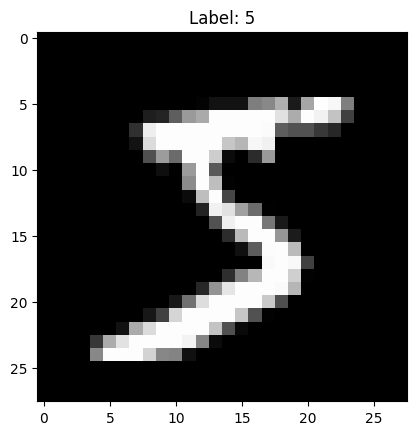

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import os
import numpy as np
import matplotlib.pyplot as plt

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Save the dataset locally as a compressed .npz file
np.savez_compressed('mnist.npz', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

# Print the current working directory to verify the file location
print("Current working directory:", os.getcwd())

# List the contents of the current directory
print("Directory contents:", os.listdir(os.getcwd()))

# Load the saved dataset from the .npz file
data = np.load('mnist.npz')

# Check what keys (arrays) are stored in the file
print("Arrays stored in the file:", data.files)

# Check the shape of the training data
print("Training data shape:", data['x_train'].shape)
print("Training labels shape:", data['y_train'].shape)

# Check the shape of the test data
print("Test data shape:", data['x_test'].shape)
print("Test labels shape:", data['y_test'].shape)

# Display a sample image from the training dataset
plt.imshow(data['x_train'][0], cmap='gray')
plt.title(f"Label: {data['y_train'][0]}")
plt.show()
